In [1]:
from manim import *

config.media_width = "100%"
_RV = "-v WARNING -qm --progress_bar None --disable_caching Example"
_RI = "-v WARNING -s --progress_bar None --disable_caching Example"

Manim Community v0.17.2

In [2]:
from scipy import integrate
import numdifftools as nd

import matplotlib.pyplot as plt

## Clase `CargaPuntual2D` (modificación)

También sirve para el campo eléctrico de una esfera cargada en la parte de afuera de dicha esfera.

Agregar el radio como parámetros y no dar campo dentro de la esfera.

In [12]:
class CargaPuntual2D(VMobject):

    def __init__(self, pos=np.array([0, 0, 0]), q=1.6e-19, q_draw=1, radio=0.15):
        
        super().__init__()
        
        self.pos = pos
        self.q = q
        self.q_draw = q_draw
        self.radio = radio
        self.k = 8.99e9
        
        self.create()
        
        
    def create(self):
        
        carga = Circle(radius=self.radio, color=RED_B if self.q_draw > 0 else BLUE_B)\
                .set_fill(RED_E if self.q_draw > 0 else BLUE_E, 1).move_to(self.pos)
        
        self.add(carga)
        
        
    def campo(self, r, q, k):
        
        x, y, z = r
        
        # validar en donde esta la carga y su interior, porque ahi el campo se hará cero
        # ya que no podrá pasar nunca a la parte de adentro un dipolo (o un virus)
        if (x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2 < self.radio**2:
            return np.array([0, 0 ,0])
        
        denominador = (((x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2)**(3/2))
        
        return np.array([
            k * (x - self.pos[0]) * q / denominador if denominador != 0 else 0, # x coord
            k * (y - self.pos[1]) * q / denominador if denominador != 0 else 0, # y coord
            k * (z - self.pos[2]) * q / denominador if denominador != 0 else 0  # z coord
        ])
    
    
    def campo_draw(self, r):
        return self.campo(r, self.q_draw, 1)
    
    
    def campo_real(self, r):
        return self.campo(r, self.q, self.k)


In [10]:
class Example(Scene):
    
    def construct(self):
        
        fields = [
            CargaPuntual2D(q_draw=-1, radio=0.2),
            CargaPuntual2D(pos=np.array([5, 2, 0]), radio=1),
            CargaPuntual2D(pos=np.array([-3, -3, 0]), q_draw=-1),
            CargaPuntual2D(pos=np.array([-4, 1, 0]))
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        # Semi-Normalized
        vector_field_norm = ArrowVectorField(func_e_field)
        # Not normalized
        vector_field_not_norm = ArrowVectorField(func_e_field, length_func=linear)
        self.play(*map(GrowArrow, vector_field_norm))
        self.wait(3)
        self.play(
            ReplacementTransform(
                vector_field_norm,
                vector_field_not_norm
            )
        )
        self.wait(3)


%manim $_RV

### Clase `DipoloElectrico2D`

In [13]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, pos=np.array([6e-3, 6e-3, 0]), 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-16, fields=[], 
                 pos_draw=np.array([0, 0, 0]),
                 longitud_escala=[40e-9, 140e-9], fps=30,
                 set_time_interval=True):
        
        super().__init__()
        
        self.angle = angle  # con respecto al eje horizontal del sistema coordenado de referencia
        self.pos = pos
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m
        self.fields = fields
        self.pos_draw = pos_draw
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        self.set_time_interval = set_time_interval
        
        self.dE = nd.Jacobian(self.campo_en_punto) # gradiente o jacobiano, es lo mismo ya que es una función vectorial
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)
        
        self.move_to(self.pos_draw)
        

    def calculate_dynamics(self):
        
        theta = self.angle  # angulo inicial
        omega = 0.0         # velocidad angular inicial
        
        p, l = self.momento_dipolar(theta, self.pos)
        
        I = self.momento_inercia_esfera_solida(self.m, l)
        
        E = self.campo_en_punto(self.pos)

        # calculos para ver como son los números y sus ordenes de magnitud (la menos al inicio del desma)

        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        dE_r = self.dE(self.pos)
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
        print("theta =", theta)
        print("self.pos[0] =", self.pos[0])
        print("l =", l)
        print("p =", p)
        print("I =", I)
        print("E =", E)
        print('tau =', tau)
        print("dE_r =", dE_r)
        print("alpha =", tau / I)
        print("a_x =", ax)
        print("------------")
        print("iterations =", self.t_end * self.fps + 2)
        print("[theta, omega] = ", [theta, omega])

        
        
        self.count_steps = 0

        self.solution = integrate.solve_ivp(self.movimiento_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [self.pos[0], self.pos[1], self.pos[2], 0, 0, 0, theta, omega],
                                            method='Radau',#'RK45'
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2)
                                                   if self.set_time_interval else None
                                           )
                                              
    
    def movimiento_dipolo(self, t, y):
        
        r = y[0:6]          # componentes de la traslacion
        theta = y[6:8]      # componentes de la rotación
        
        pos = r[0:3]        # posicion actual
        angle = theta[0]    # angulo actual
        
        p, l = self.momento_dipolar(angle, pos)  # en posicion actual
        
        y_traslacion = self.traslacion_dipolo(t, r, p)
        
        y_angulo = self.angulo_dipolo(t, theta, pos, p, l)
        
        return np.concatenate((y_traslacion, y_angulo))
        
        
        
    def angulo_dipolo(self, t, theta, pos, p, l):
    
        self.count_steps = self.count_steps + 1
    
        # componentes
        x, v = theta    # x: theta, v: omega
        
        I = self.momento_inercia_esfera_solida(self.m, l) # en posicion actual
        
        E = self.campo_en_punto(pos)         # en posicion actual
        
        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        
        a = tau / I if I != 0 else 0  # el signo ya lo trae tau

        return [v, a]  # velocidad (omega, primera derivada) y aceleración (alpha, segunda derivada)
    
    
    def traslacion_dipolo(self, t, r, p):
        
        
        # componentes
        x, y, z, vx, vy, vz = r
        
        dE_r = self.dE([x, y, z])
        
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/self.m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/self.m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]

    
    def momento_dipolar(self, angle, center_pos):
        
        # asumiendo que el centro de ele está en center_pos
        r_pos = np.array([(self.ele/2)*np.cos(angle), (self.ele/2)*np.sin(angle), 0]) + center_pos   # carga positva
        r_neg = np.array([-(self.ele/2)*np.cos(angle), -(self.ele/2)*np.sin(angle), 0]) + center_pos # carga negativa
        
        l = r_pos - r_neg
        p = l * self.q1
        
        return p, l
    

    def momento_inercia_barra(self, m, l):

        return m * np.linalg.norm(l)**2 / 12
    
        
    def momento_inercia_dos_masas(self, m, l): 
        # m es la masa total, entonces m1 = m2 = m/2
        # usa la masa reducida = m1m2/(m1+m2) = (m^2/4) / (m) = m/4
        
        return m * np.linalg.norm(l)**2 / 4
    
    
    def momento_inercia_esfera_solida(self, m, l):
        # aqui se considera el radio (no el diametro)
        
        return 2 * m * (np.linalg.norm(l)/2)**2 / 5
    
    
    def campo_en_punto(self, r):
        
        total_field = np.array([0., 0., 0.])
        for field in self.fields:
            total_field += field.campo_real(r)
        
        return total_field
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

In [27]:
fields = [
    CargaPuntual2D(q_draw=-1, radio=0.2, q=1.6e-14),
    CargaPuntual2D(pos=np.array([5, 2, 0]), radio=1, q=1.6e-14),
    CargaPuntual2D(pos=np.array([-3, -3, 0]), q_draw=-1, q=1.6e-14),
    CargaPuntual2D(pos=np.array([-4, 1, 0]), q=1.6e-14)
]


dipolo = DipoloElectrico2D(7*PI/12, pos_draw=np.array([1, 1, 0]), t_end=30,  # angle = PI/3 + PI/4
                           fps=30, 
                           fields=fields, pos=np.array([1, 1, 0]))

theta = 1.832595714594046
self.pos[0] = 1
l = [-3.62346664e-08  1.35229616e-07  0.00000000e+00]
p = [-5.79754662e-27  2.16367385e-26  0.00000000e+00]
I = 1.9599999987350336e-31
E = [5.15786178e-05 5.19814280e-05 0.00000000e+00]
tau = -1.4173578172267981e-30
dE_r = [[-3.18684371e-05 -7.89231635e-05  0.00000000e+00]
 [-7.89231635e-05 -2.29841505e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.48525877e-05]]
alpha = -7.231417439497695
a_x = -1.522881100518844e-14
------------
iterations = 902
[theta, omega] =  [1.832595714594046, 0.0]


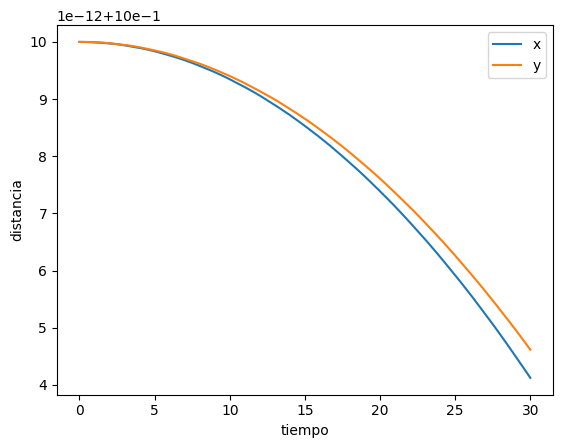

In [28]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

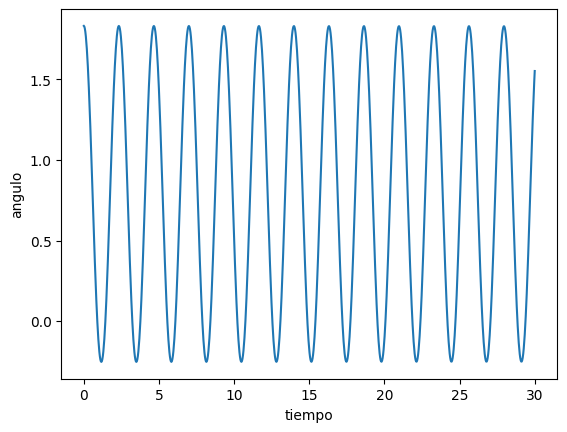

In [29]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [32]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            CargaPuntual2D(q_draw=-1, radio=0.2, q=1.6e-14),
            CargaPuntual2D(pos=np.array([5, 2, 0]), radio=1, q=1.6e-14),
            CargaPuntual2D(pos=np.array([-3, -3, 0]), q_draw=-1, q=1.6e-14),
            CargaPuntual2D(pos=np.array([-4, 1, 0]), q=1.6e-14)
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = 7*PI/12 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields, 
                                   pos=np.array([1, 1, 0]),
                                   longitud_escala=[140e-9, 420e-9])
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([(mob.solution.y[0][mob._counter]-10e-1)/1e-12 + mob.pos_draw[0], 
                         (mob.solution.y[1][mob._counter]-10e-1)/1e-12 + mob.pos_draw[1], 
                         (mob.solution.y[2][mob._counter]-10e-1)/1e-12 + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        dipolo.set_z_index(11)
        
        
        self.wait(TOTAL_TIME)
        

%time %manim $_RV

theta = 1.832595714594046
self.pos[0] = 1
l = [-3.62346664e-08  1.35229616e-07  0.00000000e+00]
p = [-5.79754662e-27  2.16367385e-26  0.00000000e+00]
I = 1.9599999987350336e-31
E = [5.15786178e-05 5.19814280e-05 0.00000000e+00]
tau = -1.4173578172267981e-30
dE_r = [[-3.18684371e-05 -7.89231635e-05  0.00000000e+00]
 [-7.89231635e-05 -2.29841505e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.48525877e-05]]
alpha = -7.231417439497695
a_x = -1.522881100518844e-14
------------
iterations = 902
[theta, omega] =  [1.832595714594046, 0.0]


CPU times: total: 2min 37s
Wall time: 2min 38s


Animación sin cambiar escala en el desplazamiento:

In [33]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            CargaPuntual2D(q_draw=-1, radio=0.2, q=1.6e-14),
            CargaPuntual2D(pos=np.array([5, 2, 0]), radio=1, q=1.6e-14),
            CargaPuntual2D(pos=np.array([-3, -3, 0]), q_draw=-1, q=1.6e-14),
            CargaPuntual2D(pos=np.array([-4, 1, 0]), q=1.6e-14)
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = 7*PI/12 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields, 
                                   pos=np.array([1, 1, 0]),
                                   longitud_escala=[140e-9, 420e-9])
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([mob.solution.y[0][mob._counter] + mob.pos_draw[0], 
                         mob.solution.y[1][mob._counter] + mob.pos_draw[1], 
                         mob.solution.y[2][mob._counter] + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        dipolo.set_z_index(11)
        
        
        self.wait(TOTAL_TIME)
        

%time %manim $_RV

theta = 1.832595714594046
self.pos[0] = 1
l = [-3.62346664e-08  1.35229616e-07  0.00000000e+00]
p = [-5.79754662e-27  2.16367385e-26  0.00000000e+00]
I = 1.9599999987350336e-31
E = [5.15786178e-05 5.19814280e-05 0.00000000e+00]
tau = -1.4173578172267981e-30
dE_r = [[-3.18684371e-05 -7.89231635e-05  0.00000000e+00]
 [-7.89231635e-05 -2.29841505e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.48525877e-05]]
alpha = -7.231417439497695
a_x = -1.522881100518844e-14
------------
iterations = 902
[theta, omega] =  [1.832595714594046, 0.0]


CPU times: total: 2min 43s
Wall time: 2min 45s


### Placas con velocidad inicial del dipolo

In [34]:
class Placas2D(VMobject):

    def __init__(self, ancho=0.5, alto=7.5, E=500e3, E_draw=1):
        
        super().__init__()
        
        self.ancho = ancho
        self.alto = alto
        self.E = E
        self.E_draw = E_draw
        self.create()
        
        
    def create(self):
        
        placa_positiva = Rectangle(width=self.ancho, height=self.alto, color=RED_B)\
                         .set_fill(RED_E, 1).move_to(LEFT * (7.0 - self.ancho))
        placa_negativa = Rectangle(width=self.ancho, height=self.alto, color=BLUE)\
                         .set_fill(BLUE_E, 1).move_to(RIGHT * (7.0 - self.ancho))
        
        self.add(placa_positiva, placa_negativa)
        
        
    def campo(self, p, E_mag):
        
        E = 0
        
        height_half_screen = ScreenRectangle().height
        
        # hay campo solo en el espacio entre las placas
        if p[0] > (LEFT[0] * (7.0 - self.ancho)) \
            and p[0] < (RIGHT[0] * (7.0 - self.ancho)) \
            and p[1] > -height_half_screen + (height_half_screen - self.alto / 2) \
            and p[1] < height_half_screen - (height_half_screen - self.alto / 2):
                E = E_mag
        
        return np.array([
            E, # x
            0, # y
            0  # z
        ])

    
    def campo_draw(self, p):
        return self.campo(p, self.E_draw)
    
    
    def campo_real(self, p):
        return self.campo(p, self.E)

In [36]:
fields = [
    Placas2D(E=1.6e-5)
]


dipolo = DipoloElectrico2D(PI/4, pos_draw=np.array([1, 1, 0]), t_end=30,
                           fps=30, pos=np.array([-3, 0, 0]),
                           fields=fields)

%time

theta = 0.7853981633974483
self.pos[0] = -3
l = [9.89949491e-08 9.89949494e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.959999995266091e-31
E = [1.6e-05 0.0e+00 0.0e+00]
tau = -2.5342707037725864e-31
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -1.2929952601497492
a_x = 0.0
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]
CPU times: total: 0 ns
Wall time: 0 ns


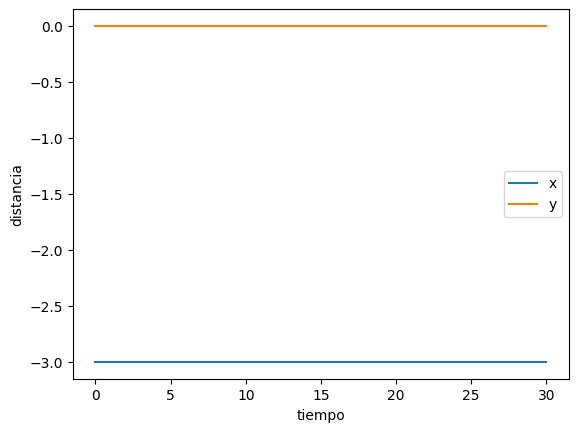

In [37]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

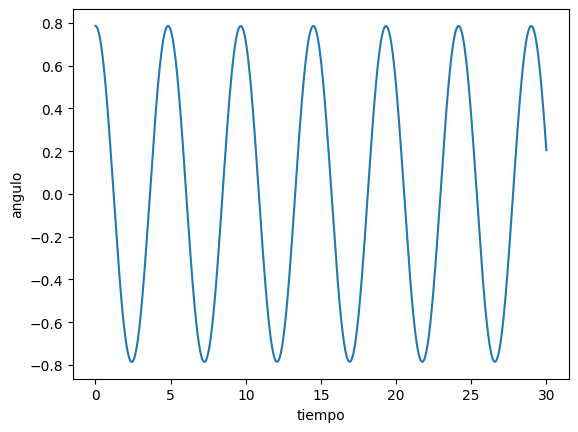

In [38]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

### Indicar velocidad inicial en `DipoloElectrico2D`

In [40]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, pos=np.array([6e-3, 6e-3, 0]), 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-16, fields=[], 
                 pos_draw=np.array([0, 0, 0]),
                 longitud_escala=[40e-9, 140e-9], fps=30,
                 set_time_interval=True,
                 velocidad_inicial=np.array([0, 0, 0])):
        
        super().__init__()
        
        self.angle = angle  # con respecto al eje horizontal del sistema coordenado de referencia
        self.pos = pos
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m
        self.fields = fields
        self.pos_draw = pos_draw
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        self.set_time_interval = set_time_interval
        self.velocidad_inicial = velocidad_inicial
        
        self.dE = nd.Jacobian(self.campo_en_punto) # gradiente o jacobiano, es lo mismo ya que es una función vectorial
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)
        
        self.move_to(self.pos_draw)
        

    def calculate_dynamics(self):
        
        theta = self.angle  # angulo inicial
        omega = 0.0         # velocidad angular inicial
        
        p, l = self.momento_dipolar(theta, self.pos)
        
        I = self.momento_inercia_esfera_solida(self.m, l)
        
        E = self.campo_en_punto(self.pos)

        # calculos para ver como son los números y sus ordenes de magnitud (la menos al inicio del desma)

        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        dE_r = self.dE(self.pos)
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
        print("theta =", theta)
        print("self.pos[0] =", self.pos[0])
        print("l =", l)
        print("p =", p)
        print("I =", I)
        print("E =", E)
        print('tau =', tau)
        print("dE_r =", dE_r)
        print("alpha =", tau / I)
        print("a_x =", ax)
        print("------------")
        print("iterations =", self.t_end * self.fps + 2)
        print("[theta, omega] = ", [theta, omega])

        
        
        self.count_steps = 0

        self.solution = integrate.solve_ivp(self.movimiento_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [self.pos[0], self.pos[1], self.pos[2], 
                                             self.velocidad_inicial[0], self.velocidad_inicial[1], 
                                             self.velocidad_inicial[2], 
                                             theta, omega],
                                            method='Radau',#'RK45'
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2)
                                                   if self.set_time_interval else None
                                           )
                                              
    
    def movimiento_dipolo(self, t, y):
        
        r = y[0:6]          # componentes de la traslacion
        theta = y[6:8]      # componentes de la rotación
        
        pos = r[0:3]        # posicion actual
        angle = theta[0]    # angulo actual
        
        p, l = self.momento_dipolar(angle, pos)  # en posicion actual
        
        y_traslacion = self.traslacion_dipolo(t, r, p)
        
        y_angulo = self.angulo_dipolo(t, theta, pos, p, l)
        
        return np.concatenate((y_traslacion, y_angulo))
        
        
        
    def angulo_dipolo(self, t, theta, pos, p, l):
    
        self.count_steps = self.count_steps + 1
    
        # componentes
        x, v = theta    # x: theta, v: omega
        
        I = self.momento_inercia_esfera_solida(self.m, l) # en posicion actual
        
        E = self.campo_en_punto(pos)         # en posicion actual
        
        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        
        a = tau / I if I != 0 else 0  # el signo ya lo trae tau

        return [v, a]  # velocidad (omega, primera derivada) y aceleración (alpha, segunda derivada)
    
    
    def traslacion_dipolo(self, t, r, p):
        
        
        # componentes
        x, y, z, vx, vy, vz = r
        
        dE_r = self.dE([x, y, z])
        
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/self.m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/self.m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]

    
    def momento_dipolar(self, angle, center_pos):
        
        # asumiendo que el centro de ele está en center_pos
        r_pos = np.array([(self.ele/2)*np.cos(angle), (self.ele/2)*np.sin(angle), 0]) + center_pos   # carga positva
        r_neg = np.array([-(self.ele/2)*np.cos(angle), -(self.ele/2)*np.sin(angle), 0]) + center_pos # carga negativa
        
        l = r_pos - r_neg
        p = l * self.q1
        
        return p, l
    

    def momento_inercia_barra(self, m, l):

        return m * np.linalg.norm(l)**2 / 12
    
        
    def momento_inercia_dos_masas(self, m, l): 
        # m es la masa total, entonces m1 = m2 = m/2
        # usa la masa reducida = m1m2/(m1+m2) = (m^2/4) / (m) = m/4
        
        return m * np.linalg.norm(l)**2 / 4
    
    
    def momento_inercia_esfera_solida(self, m, l):
        # aqui se considera el radio (no el diametro)
        
        return 2 * m * (np.linalg.norm(l)/2)**2 / 5
    
    
    def campo_en_punto(self, r):
        
        total_field = np.array([0., 0., 0.])
        for field in self.fields:
            total_field += field.campo_real(r)
        
        return total_field
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

In [42]:
%%time

fields = [
    Placas2D(E=1.6e-5)
]


dipolo = DipoloElectrico2D(PI/4, pos_draw=np.array([1, 1, 0]), t_end=30,
                           fps=30, pos=np.array([-3, 0, 0]),
                           fields=fields)

theta = 0.7853981633974483
self.pos[0] = -3
l = [9.89949491e-08 9.89949494e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.959999995266091e-31
E = [1.6e-05 0.0e+00 0.0e+00]
tau = -2.5342707037725864e-31
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -1.2929952601497492
a_x = 0.0
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]
CPU times: total: 1min 2s
Wall time: 1min 2s


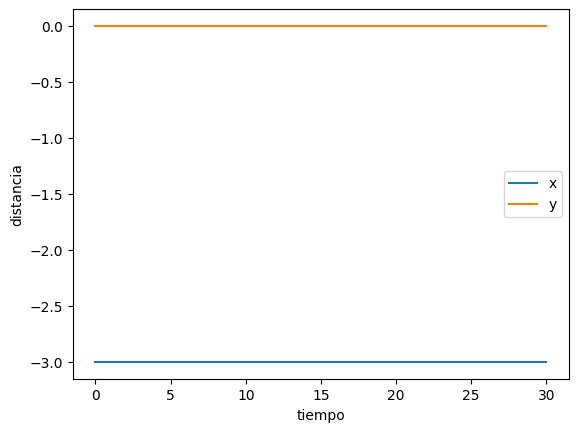

In [43]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

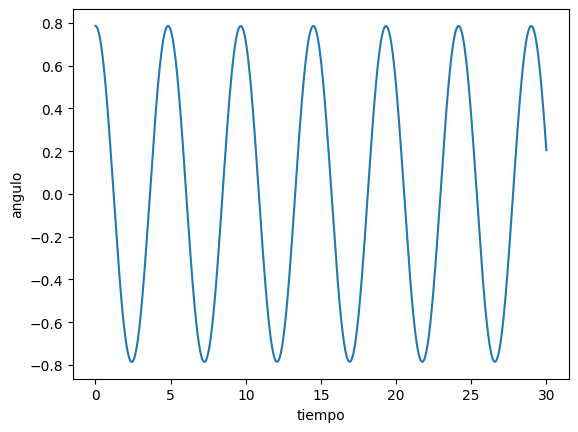

In [44]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [45]:
for v in dipolo.solution.y[3]:
    print(f"{v:.50f}")

0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000

In [73]:
%%time

fields = [
    Placas2D(E=1.6e-5)
]


dipolo = DipoloElectrico2D(PI/4, pos_draw=np.array([1, 1, 0]), t_end=30,
                           fps=30, pos=np.array([0, -3, 0]),
                           fields=fields,
                           velocidad_inicial=np.array([0.14, 0.2, 0]))

theta = 0.7853981633974483
self.pos[0] = 0
l = [9.89949494e-08 9.89949491e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.959999995266091e-31
E = [1.6e-05 0.0e+00 0.0e+00]
tau = -2.5342706976516635e-31
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -1.2929952570268293
a_x = 0.0
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]
CPU times: total: 1min 3s
Wall time: 1min 4s


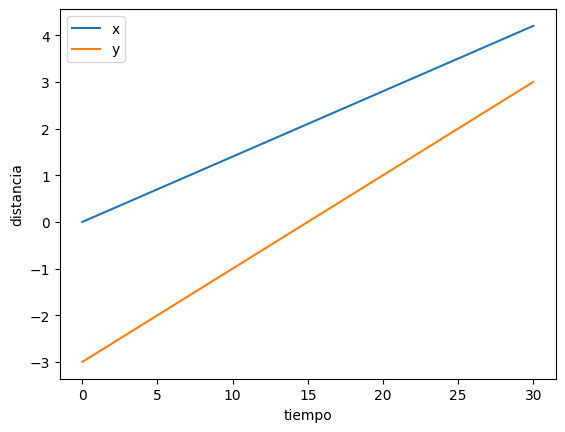

In [69]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

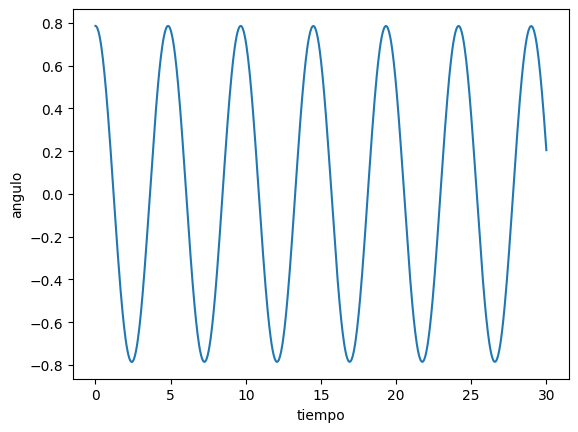

In [70]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [71]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            Placas2D(E=1.6e-5)
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = PI/4 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields, 
                                   pos=np.array([0, -3, 0]),
                                   longitud_escala=[140e-9, 420e-9],
                                   velocidad_inicial=np.array([0.01, 0.1, 0]))
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([mob.solution.y[0][mob._counter] + mob.pos_draw[0], 
                         mob.solution.y[1][mob._counter] + mob.pos_draw[1], 
                         mob.solution.y[2][mob._counter] + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        dipolo.set_z_index(11)
        
        
        self.wait(TOTAL_TIME)
        

%time %manim $_RV

theta = 0.7853981633974483
self.pos[0] = 0
l = [9.89949494e-08 9.89949491e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.959999995266091e-31
E = [1.6e-05 0.0e+00 0.0e+00]
tau = -2.5342706976516635e-31
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -1.2929952570268293
a_x = 0.0
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]


CPU times: total: 3min 40s
Wall time: 3min 43s


### Campo grande como el que menciona el doc de Yacamán

Sin indicar el `t_eval`:

In [87]:
%%time

fields = [
    Placas2D() # valor default de E=500e3
]


dipolo = DipoloElectrico2D(PI/4, pos_draw=np.array([0, 0, 0]), t_end=0.03,
                           fps=30, pos=np.array([0, 0, 0]),
                           fields=fields,
                           set_time_interval=False)

theta = 0.7853981633974483
self.pos[0] = 0
l = [9.89949494e-08 9.89949494e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.9600000000000001e-31
E = [500000.      0.      0.]
tau = -7.919595949289333e-21
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -40406101782.08843
a_x = 0.0
------------
iterations = 2.9
[theta, omega] =  [0.7853981633974483, 0.0]
CPU times: total: 1h 59min 34s
Wall time: 2h 56s


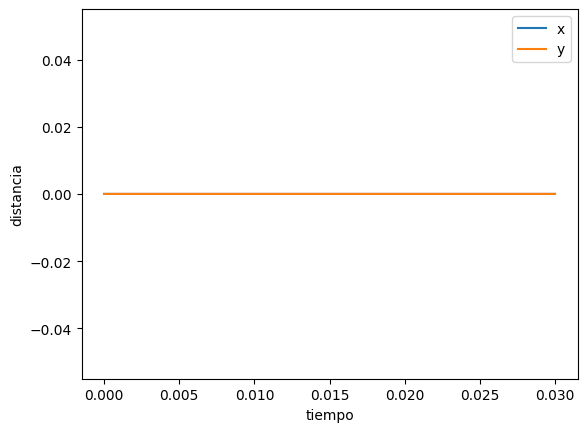

In [88]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

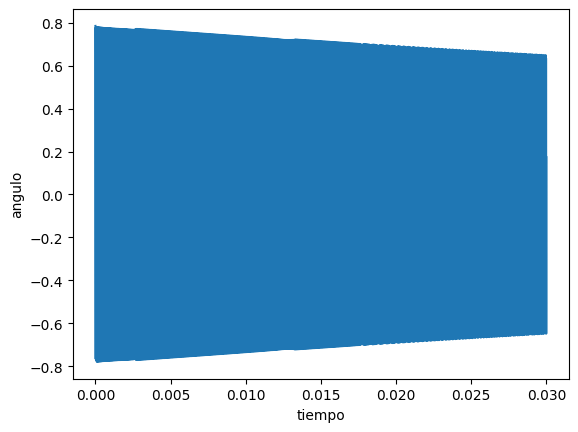

In [89]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [90]:
len(dipolo.solution.t)

9667

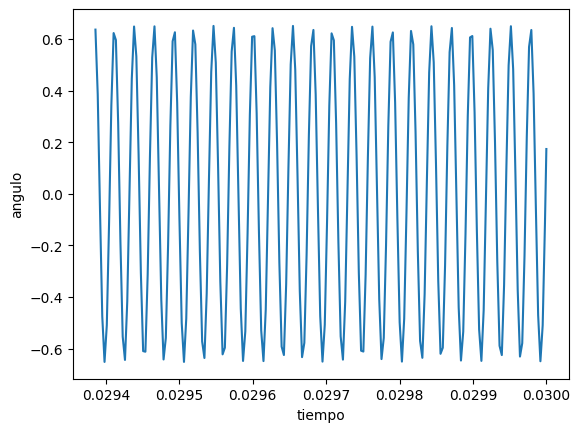

In [91]:
plt.plot(dipolo.solution.t[9467:9667], dipolo.solution.y[6][9467:9667])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

Un campo más complicado (varias cargas puntuales)

In [104]:
%%time

fields = [
    CargaPuntual2D(q_draw=-1, q=1.6e-4),
    CargaPuntual2D(pos=np.array([5, 2, 0]), q=1.6e-4),
    CargaPuntual2D(pos=np.array([-3, -3, 0]), q_draw=-1, q=1.6e-4),
    CargaPuntual2D(pos=np.array([-4, 1, 0]), q=1.6e-4)
]


dipolo = DipoloElectrico2D(7*PI/12, pos_draw=np.array([1, 1, 0]), t_end=0.03,  # angle = PI/3 + PI/4
                           fps=30, 
                           fields=fields, pos=np.array([1, 1, 0]),
                           set_time_interval=False)

theta = 1.832595714594046
self.pos[0] = 1
l = [-3.62346664e-08  1.35229616e-07  0.00000000e+00]
p = [-5.79754662e-27  2.16367385e-26  0.00000000e+00]
I = 1.9599999987350336e-31
E = [515786.17789023 519814.27960533      0.        ]
tau = -1.4173578172267984e-20
dE_r = [[-318684.37147025 -789231.6352162        0.        ]
 [-789231.6352162  -229841.50525108       0.        ]
 [      0.               0.          548525.87672132]]
alpha = -72314174394.97696
a_x = -0.00015228811005187618
------------
iterations = 2.9
[theta, omega] =  [1.832595714594046, 0.0]
CPU times: total: 12min 59s
Wall time: 13min 2s


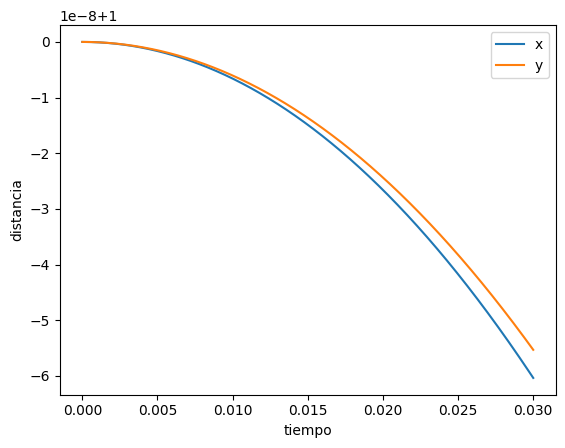

In [105]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

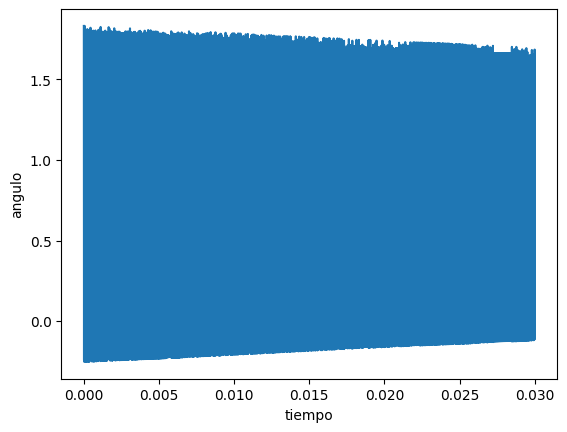

In [106]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [107]:
%%time

fields = [
    CargaPuntual2D(q_draw=-1, q=1.6e-4),
    CargaPuntual2D(pos=np.array([5, 2, 0]), q=1.6e-4),
    CargaPuntual2D(pos=np.array([-3, -3, 0]), q_draw=-1, q=1.6e-4),
    CargaPuntual2D(pos=np.array([-4, 1, 0]), q=1.6e-4)
]


dipolo = DipoloElectrico2D(7*PI/12, pos_draw=np.array([1, 1, 0]), t_end=0.3,  # angle = PI/3 + PI/4
                           fps=30, 
                           fields=fields, pos=np.array([1, 1, 0]),
                           set_time_interval=False)

theta = 1.832595714594046
self.pos[0] = 1
l = [-3.62346664e-08  1.35229616e-07  0.00000000e+00]
p = [-5.79754662e-27  2.16367385e-26  0.00000000e+00]
I = 1.9599999987350336e-31
E = [515786.17789023 519814.27960533      0.        ]
tau = -1.4173578172267984e-20
dE_r = [[-318684.37147025 -789231.6352162        0.        ]
 [-789231.6352162  -229841.50525108       0.        ]
 [      0.               0.          548525.87672132]]
alpha = -72314174394.97696
a_x = -0.00015228811005187618
------------
iterations = 11.0
[theta, omega] =  [1.832595714594046, 0.0]
CPU times: total: 1h 59min 17s
Wall time: 2h 17s


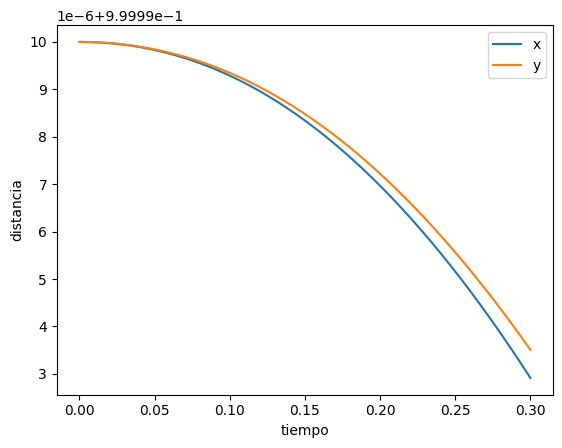

In [108]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

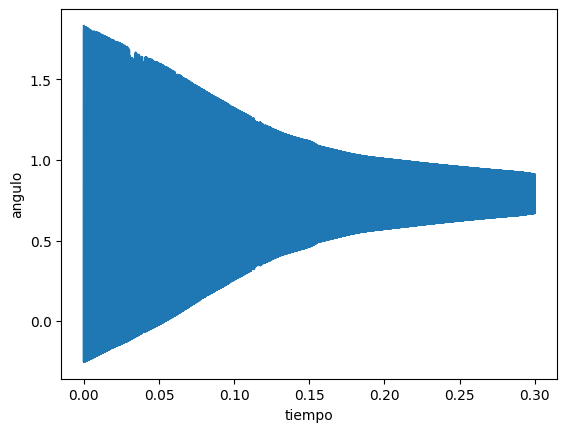

In [109]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

Usando mi metodo numérico:

In [83]:
# [https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Fehlberg]

# Método Runge–Kutta–Fehlberg (o método de Fehlberg)
# método de orden O(h^4) con un estimador de error de orden O(h^5)

def rk45(f, t0, y0, nmax, h):
    
    # f:    función
    # t0:   tiempo inicial
    # y0:   valor inicial (vector)
    # nmax: número de iteraciones
    # h:    tamaño del paso
    
    y = y0
    t = t0
    t_values = [t]
    y_values = [y]
    
    for i in range(1, nmax+1):
        
        k1 = h * f(t, y)
        k2 = h * f(t + h/4, y + k1/4)
        k3 = h * f(t + h*3/8, y + k1*3/32 + k2*9/32)
        k4 = h * f(t + h*12/13, y + k1*1932/2197 - k2*7200/2197 + k3*7296/2197)
        k5 = h * f(t + h, y + k1*439/216 - k2*8 + k3*3680/513 - k4*845/4104)
        k6 = h * f(t + h*1/2, y - k1*8/27 + k2*2 - k3*3544/2565 + k4*1859/4104 - k5*11/40)
        k = 16/135*k1 + 0*k2 + 6656/12825*k3 + 28561/56430*k4 - 9/50*k5 + 2/55*k6
        y = y + k
        t = t + h
        t_values.append(t)
        y_values.append(y)
        
    return [t_values, y_values]